In [1]:
# Libraries
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.metrics import Metric
from itertools import product

In [2]:
# Connect Drive
from google.colab import drive
drive.mount(r'/content/drive',force_remount = True)
%cd /content/drive/MyDrive/LSTM

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1EYcDfRZdNbAHFL8-gaMUF8Pj27Tm8qYu/LSTM


# Data loading

First, let's download the clean datasets that we will use as train, validation, and test sets for the LSTM.

In [3]:
# Read train dataset
with open(file = '/content/drive/MyDrive/LSTM/data/lstm_train.json') as f:
    train_tuple = json.load(f)

# Read validation dataset
with open(file = '/content/drive/MyDrive/LSTM/data/lstm_val.json') as f:
    val_tuple = json.load(f)

# Read test dataset
with open(file = '/content/drive/MyDrive/LSTM/data/lstm_test.json') as f:
    test_tuple = json.load(f)

# Read char map dictionary
with open(file = '/content/drive/MyDrive/LSTM/data/lstm_char_map.json') as f:
    lstm_char_map = json.load(f)

In [9]:
# Divide into symbols, features and targets
train_symbols, train_features, train_target = map(np.array, train_tuple)
val_symbols, val_features, val_target = map(np.array, val_tuple)
test_symbols, test_features, test_target = map(np.array, test_tuple)

# LSTM model


The next cell contains the function *LSTM_model* that, given as input the hyperparameters embedding dimension, feature embedding dimension, hidden units and dropout, defines the LSTM model

In [ ]:
def LSTM_model(embedding_dim, feature_embedding_dim, hidden_units, dropout_rate=0.25, vocab_size=60):
  '''
  Given LSTM hyperparameters define the LSTM model
  '''
  # Input symbol and features
  input_symbol = Input(shape=(None,))
  input_features = Input(shape=(None, 4))

  # Embed symbols
  embedded_symbol = Embedding(vocab_size, embedding_dim)(input_symbol)

  # Embed features
  embedded_features = Dense(units=feature_embedding_dim)(input_features)

  # Concatenate embedded symbol and features
  merged_input = Concatenate(axis=-1)([embedded_symbol, embedded_features])

  # Encoder
  encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
  encoder_outputs, state_h, state_c = encoder_lstm(merged_input)
  encoder_states = [state_h, state_c]

  # Add dropout to encoder LSTM
  encoder_outputs = Dropout(dropout_rate)(encoder_outputs)

  # Decoder
  decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(embedded_symbol, initial_state = encoder_states)

  # Add dropout to decoder LSTM
  decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

  # Attention layer
  attention_layer = Attention(use_scale=True)
  context_vector = attention_layer([decoder_outputs, encoder_outputs])

  # Concatenate
  merged_output = Concatenate(axis=-1)([decoder_outputs, context_vector])

  # Output
  output_seq = Dense(vocab_size, activation="softmax")(merged_output)

  return Model(inputs = [input_symbol, input_features], outputs = output_seq)

In the next cell, we define our customized accuracy, which will be used during the training phase. Specifically, it is the *sequence accuracy* or *overall accuracy*, computed as the number of entirely correctly translated sequences divided by the total number of sequence samples.


In [4]:
# Here is defined our sequence accuracy metric that we'll use during the training phase
@tf.keras.utils.register_keras_serializable()
class SeqAccuracy(Metric):
    def __init__(self, name='seq_accuracy', **kwargs):
        super(SeqAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), dtype=tf.float32)
        N = tf.shape(y_true)[0]
        k = 0
        for i in range(N):
            if tf.reduce_all(tf.math.equal(y_true[i, :], y_pred[i, :])):
                k += 1

        self.total.assign_add(tf.cast(k, tf.float32))
        self.count.assign_add(tf.cast(N, tf.float32))

    def result(self):
        return tf.cond(
            tf.math.not_equal(self.count, 0),
            lambda: self.total / self.count,
            lambda: tf.constant(0.0, dtype=tf.float32)
        )

    def reset_state(self):
        self.total.assign(0)
        self.count.assign(0)

# Grid Search

In this section, we will conduct a grid search to identify the optimal combination of hyperparameters based on validation loss. Specifically, we will experiment with various values for the embedding dimension, including the feature embedding dimension, and the dropout rate.  

The following cell contains two functions that will be useful for loading and saving the model's history.

In [5]:
def save_history(path, val_loss, train_loss, val_acc, train_acc):
  '''
  Save history (validation/train loss and validation/train accuracy) at the specified path.
  '''
  with open(path + '_loss_val.json', 'w') as json_file:
    json.dump(val_loss, json_file)
  with open(path + "_loss_train.json", 'w') as json_file:
    json.dump(train_loss, json_file)
  with open(path + "_acc_val.json", 'w') as json_file:
    json.dump(val_acc, json_file)
  with open(path + "_acc_train.json", 'w') as json_file:
    json.dump(train_acc, json_file)
  return



def read_history(path):
  '''
  Read history (validation/train loss and validation/train accuracy) from the specified path.
  '''
  with open(path + '_loss_val.json', 'r') as json_file:
    val_loss = json.load(json_file)
  with open(path + "_loss_train.json", 'r') as json_file:
    train_loss = json.load(json_file)
  with open(path + "_acc_val.json", 'r') as json_file:
    val_acc = json.load(json_file)
  with open(path + "_acc_train.json", 'r') as json_file:
    train_acc = json.load(json_file)
  return val_loss, train_loss, val_acc, train_acc

The next cell contains the function *grid_search* that as the name suggests computes a grid search over the hyperparameters given in input.

Every time we train a model with a fixed combination, we also save the model at its best epoch and compare its corresponding validation loss to the *best_validation_loss*, updating it if it is smaller.

In [ ]:
def grid_search(parameters, epochs = 10):
  '''
  It computes grid search with all possible combinations of input parameters.
  '''
  # Extract train hyperparameters
  lrs = parameters['learning_rate']
  dropouts = parameters["dropout_rate"]

  # Extract model hyperparameters
  embedding_dims = parameters["embedding_dim"]
  hidden_units = parameters["hidden_units"]

  # Extract all possible combination of hyperparameters
  combinations = list(product(embedding_dims, hidden_units, lrs, dropouts))

  # Initialize best validation loss, best combo and the index of the best combo
  best_val_loss = 100
  best_combo = []
  best_combo_index = 0

  # Looping over hyperparameters combinations
  for i, combo in enumerate(combinations):

    # Plot hyperparameters
    print(f"hyperparameters : {combo}")

    # Initialize the model
    model = LSTM_model(embedding_dim = combo[0], feature_embedding_dim = combo[0]*4, hidden_units = combo[1],
                       dropout_rate = combo[3], vocab_size=60)

    # Define the optimizer
    optimizer = Adam(learning_rate = combo[2])

    # Compile the model
    model.compile(optimizer=optimizer, loss = "sparse_categorical_crossentropy", metrics = [SeqAccuracy()])

    # Define callbacks
    callbacks = [ ModelCheckpoint(f'models/best_model_gs_{i}.keras', save_best_only=True)]

    # Training
    history = model.fit(
    [train_symbols, train_features],
    train_target,
    epochs = epochs,
    callbacks = callbacks,
    batch_size = 128,
    validation_data=([val_symbols, val_features], val_target)
    )

    if min(history.history['val_loss']) < best_val_loss:

      # Save model history
      save_history('models/grid_search_bm', history.history['val_loss'], history.history['loss'],
                   history.history['val_seq_accuracy'], history.history['seq_accuracy'])

      # Update best validation loss, best combo and best combo index
      best_val_loss = min(history.history['val_loss'])
      best_combo_index = i
      best_combo = combo

  return combinations, best_val_loss, best_combo, best_combo_index

In [ ]:
# Hyperparameter combinations to try during the grid search
parameters = {}
parameters['embedding_dim'] = np.array([128, 256])
parameters['hidden_units'] = np.array([1024])
parameters['learning_rate'] = np.array([0.001])
parameters['dropout_rate'] = np.array([0.1, 0.2, 0.3])

# Grid search
combinations, best_val_loss, best_combo, best_combo_index = grid_search(parameters, epochs = 20)

hyperparameters : (128, 1024, 0.001, 0.1)
Epoch 1/20
195/195 [==============================] - 96s 433ms/step - loss: 1.0702 - seq_accuracy: 0.0000e+00 - val_loss: 0.9261 - val_seq_accuracy: 0.0000e+00
Epoch 2/20
195/195 [==============================] - 82s 419ms/step - loss: 0.9235 - seq_accuracy: 0.0000e+00 - val_loss: 0.8752 - val_seq_accuracy: 0.0000e+00
Epoch 3/20
195/195 [==============================] - 82s 420ms/step - loss: 0.8585 - seq_accuracy: 0.0000e+00 - val_loss: 0.8237 - val_seq_accuracy: 0.0000e+00
Epoch 4/20
195/195 [==============================] - 84s 430ms/step - loss: 0.7894 - seq_accuracy: 0.0000e+00 - val_loss: 0.7552 - val_seq_accuracy: 0.0000e+00
Epoch 5/20
195/195 [==============================] - 83s 427ms/step - loss: 0.6990 - seq_accuracy: 0.0000e+00 - val_loss: 0.6391 - val_seq_accuracy: 0.0000e+00
Epoch 6/20
195/195 [==============================] - 83s 423ms/step - loss: 0.6099 - seq_accuracy: 0.0000e+00 - val_loss: 0.5453 - val_seq_accuracy: 0.0

In [ ]:
combinations, best_val_loss, best_combo, best_combo_index

([(128, 1024, 0.001, 0.1),
  (128, 1024, 0.001, 0.2),
  (128, 1024, 0.001, 0.3),
  (256, 1024, 0.001, 0.1),
  (256, 1024, 0.001, 0.2),
  (256, 1024, 0.001, 0.3)],
 0.10242782533168793,
 (256, 1024, 0.001, 0.2),
 4)

# Train the best model for more epochs
---



In this section, we will take the best model obtained from the grid search and train it further until a total of $50$ epochs.

In [46]:
# Take the best model from the grid search and its history
best_combo_index = 4
best_model_gs = load_model(f'models/best_model_gs_{best_combo_index}.keras')
val_loss, train_loss, val_acc, train_acc = read_history('models/grid_search_bm')

In [47]:
# Compute the best epoch at which the model was saved and take the history till that point
best_epoch = np.where(val_loss == np.min(val_loss))[0][0]
val_loss = val_loss[:best_epoch+1]
train_loss = train_loss[:best_epoch+1]
val_acc = val_acc[:best_epoch+1]
train_acc = train_acc[:best_epoch+1]

# Computing the remaining epochs as total epochs - trained epochs
remaining_epochs = 50-(best_epoch+1)

In [12]:
# Train the best model for the remaining epochs so that we train the best model for 50 epochs in total
callbacks = [ ModelCheckpoint(f'models/best_model.keras', save_best_only=True)]

history_bm_gs = best_model_gs.fit(
    [train_symbols, train_features],
    train_target,
    epochs = remaining_epochs,
    callbacks = callbacks,
    batch_size = 128,
    validation_data=([val_symbols, val_features], val_target)
    )

Epoch 1/30
195/195 [==============================] - 103s 494ms/step - loss: 0.0842 - seq_accuracy: 0.4993 - val_loss: 0.1218 - val_seq_accuracy: 0.4744
Epoch 2/30
195/195 [==============================] - 97s 499ms/step - loss: 0.0782 - seq_accuracy: 0.5130 - val_loss: 0.0960 - val_seq_accuracy: 0.5710
Epoch 3/30
195/195 [==============================] - 97s 500ms/step - loss: 0.0719 - seq_accuracy: 0.5340 - val_loss: 0.0901 - val_seq_accuracy: 0.5731
Epoch 4/30
195/195 [==============================] - 98s 500ms/step - loss: 0.0571 - seq_accuracy: 0.5816 - val_loss: 0.0865 - val_seq_accuracy: 0.5951
Epoch 5/30
195/195 [==============================] - 97s 495ms/step - loss: 0.0640 - seq_accuracy: 0.5638 - val_loss: 0.0911 - val_seq_accuracy: 0.5861
Epoch 6/30
195/195 [==============================] - 97s 500ms/step - loss: 0.0540 - seq_accuracy: 0.6001 - val_loss: 0.0854 - val_seq_accuracy: 0.6035
Epoch 7/30
195/195 [==============================] - 97s 495ms/step - loss: 0.08

In [52]:
# Concatenate the history of the last epochs
train_acc.extend(history_bm_gs.history['seq_accuracy'])
val_acc.extend(history_bm_gs.history['val_seq_accuracy'])
train_loss.extend(history_bm_gs.history['loss'])
val_loss.extend(history_bm_gs.history['val_loss'])

# Save the history of the model trained with totally 50 epochs
save_history('models/best_model', val_loss, train_loss,
                   val_acc, train_acc)

In [53]:
# Load the best model trained on 50 epochs and its history
val_loss, train_loss, val_acc, train_acc = read_history('models/best_model')
best_model = load_model('models/best_model.keras')

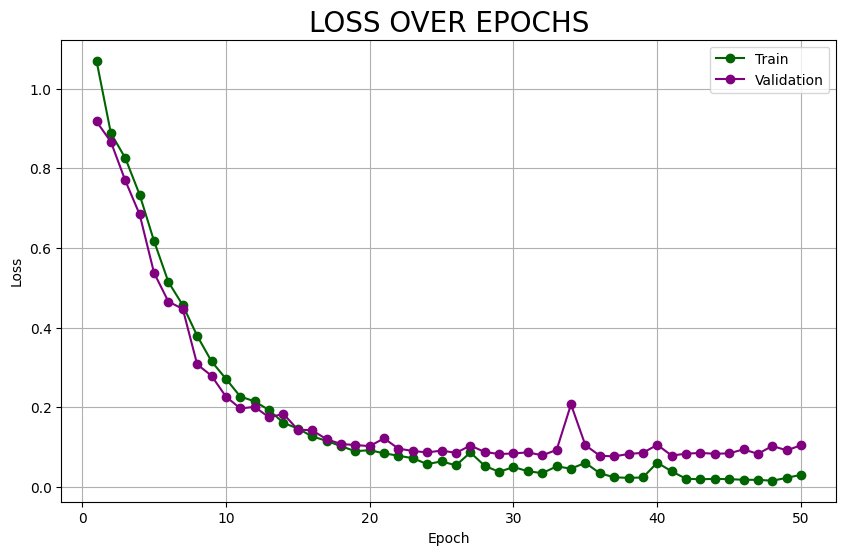

In [55]:
# Plot the loss over epochs on the train and validation set
plt.figure(figsize = (10, 6))
plt.plot(range(1, 51), train_loss, label='Train', color='darkgreen', marker = 'o')
plt.plot(range(1, 51), val_loss, label='Validation', color='purple', marker = 'o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS OVER EPOCHS', fontsize=20)
plt.show()

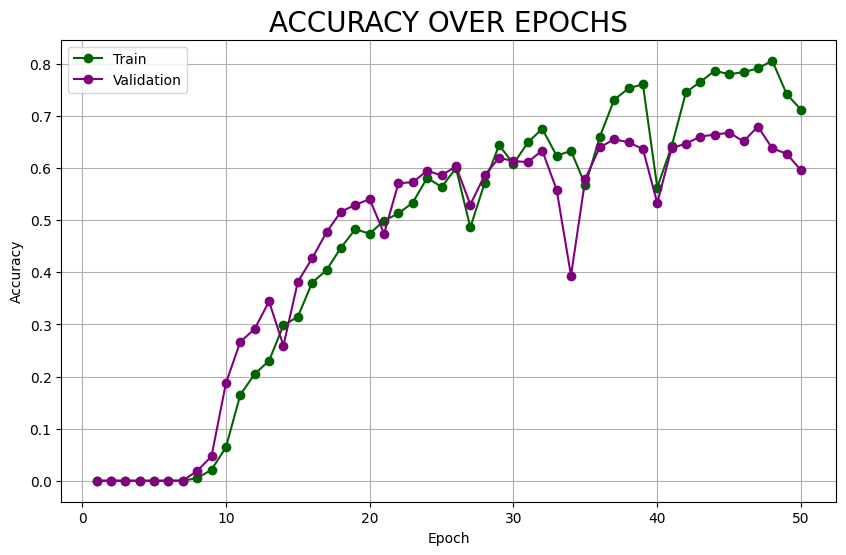

In [56]:
# Plot the sequence accuracy over epochs on the train and validation set
plt.figure(figsize = (10, 6))
plt.plot(range(1, 51), train_acc, label='Train', color='darkgreen', marker = 'o')
plt.plot(range(1, 51), val_acc, label='Validation', color='purple', marker = 'o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ACCURACY OVER EPOCHS', fontsize=20)
plt.show()

In [60]:
best_epoch = np.where(val_loss == np.min(val_loss))[0][0]
print(f'The model was saved at the epoch number {best_epoch}, with a corresponding validation loss of {round(val_loss[best_epoch],3)} and validation accuracy of {round(val_acc[best_epoch],3)}.')

The model was saved at the epoch number 36, with a corresponding validation loss of 0.076 and validation accuracy of 0.656.


# Test

In this last section we'll evaluate the performance of the *LSTM* on a test dataset.\
In particular we'll compute the overall accuracy considering different levels of patience.

In [61]:
# Compute predictions
predictions = best_model.predict([test_symbols, test_features]).argmax(axis=-1)

112/112 [==============================] - 6s 46ms/step


In [62]:
# Number of correctly predicted sequences / number of sequences.
# The argument "sort" is used only in the case of comparing sequences that have been shuffled
# (only when we are checking the results of the YOLO fine tuning)

def sequence_accuracy(preds, targets, patience = 0, sort = False):

  N = preds.shape[0]
  k = 0

  for i in range(N):
    pred = preds[i,:]
    target = targets[i,:]

    if sort:
      pred = np.array(sorted(pred))
      target = np.array(sorted(target))

    if np.sum(pred == target) >= preds.shape[1] - patience :
      k += 1
  seq_accuracy = k / preds.shape[0]
  return seq_accuracy

# Applies "sequence_accuracy" on a range of patiences
def sequence_accuracy_curve(preds, targets, sort = False, title = "",  max_patience = 30):
  # Get accuracies
  accuracies = [sequence_accuracy(preds, targets, patience = pad, sort = sort) for pad in range(max_patience)]

  fig = plt.figure(figsize=(8, 6))
  plt.plot(range(max_patience), accuracies, marker = 'o')
  plt.xlabel("Patience")
  plt.ylabel("Accuracy")
  plt.ylim(0,1.1)
  plt.title(title)
  plt.xticks(range(max_patience), range(max_patience))
  plt.grid(linestyle='--', alpha=0.5)
  plt.show()

  return accuracies

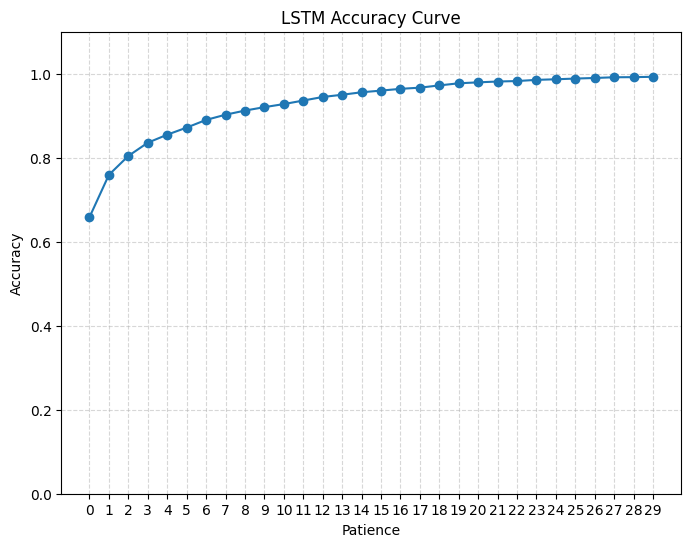

In [63]:
accuracy_values = sequence_accuracy_curve(predictions, test_target, False, 'LSTM Accuracy Curve')

In [65]:
print(f'On the test set we obtained an overall accuracy without patience of {round(accuracy_values[0],2)}')

On the test set we obtained an overall accuracy without patience of 0.66
